In [272]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import chi2

In [273]:
df = pd.read_csv('nh3.csv')
baseline = df.loc[0, 'ADC_1': 'ADC_401' ]
#baseline

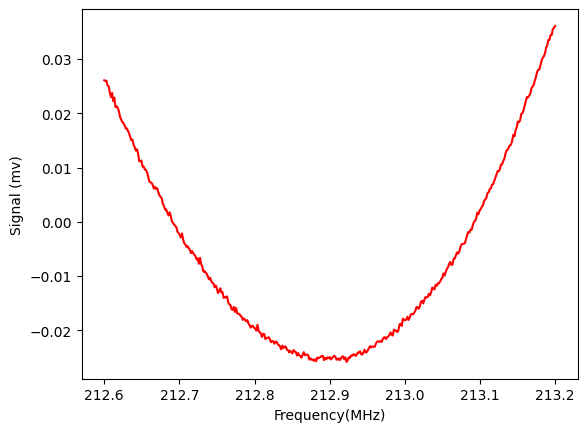

In [274]:
x_vals = np.linspace(212.60, 213.20, 401) # Make sure that the baseline is centered on Larmor frequency.
plt.plot(x_vals, baseline, label='baseline', color='red')
plt.xlabel("Frequency(MHz)")
plt.ylabel("Signal (mv)")
plt.show()

### Baseline function in curve.py file is not working for LANL data. Let's try fitting a quadratic function. We can figure out the level of noise in the data by subtracting the fit from the data.

Optimized Parameters:
a = 6.34652e-01, b = -2.70223e+02, c = 2.87639e+04
Chi-squared = 401.00
Reduced Chi-squared = 1.01
P-value = 0.4484
covariant metrix=[[ 1.67952322e-06 -7.15141080e-04  7.61267270e-02]
 [-7.15141080e-04  3.04507152e-01 -3.24147732e+01]
 [ 7.61267270e-02 -3.24147732e+01  3.45055167e+03]]


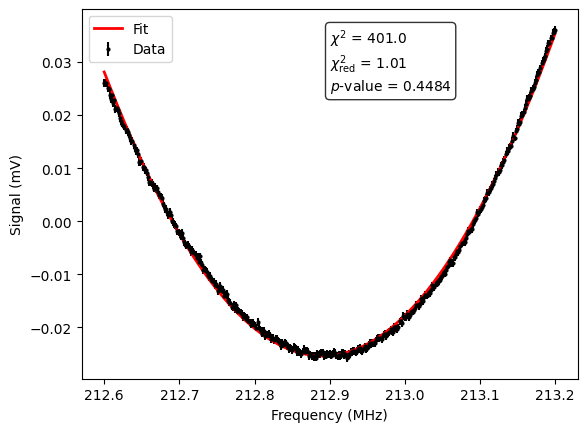

In [288]:
def quadratic(x, a, b, c):
    return a * x**2 + b * x + c

baseline = np.array(baseline, dtype=float)

p0 = np.polyfit(x_vals, baseline, 2)  # a, b, c for ax^2 + bx + c
#print(p0)

yerr = 0.0007 # Just a guess. We can always edit this error to realistic value.
popt, pcov = curve_fit(quadratic, x_vals, baseline, p0=p0, sigma=np.full_like(x_vals, yerr), absolute_sigma=True)
y_fit = quadratic(x_vals, *popt)
residuals = baseline - y_fit
chi_squared = np.sum((residuals / np.std(residuals)) ** 2)
dof = len(x_vals) - len(popt)
chi_squared_red = chi_squared / dof
p_val = 1 - chi2.cdf(chi_squared, dof)

# Print results
print("Optimized Parameters:")
print(f"a = {popt[0]:.5e}, b = {popt[1]:.5e}, c = {popt[2]:.5e}")
print(f"Chi-squared = {chi_squared:.2f}")
print(f"Reduced Chi-squared = {chi_squared_red:.2f}")
print(f"P-value = {p_val:.4f}")



print(f'covariant metrix={pcov}')

# Plot
plt.errorbar(x_vals, baseline, yerr=yerr, fmt='o', markersize=2, label='Data', color='black')
plt.plot(x_vals, y_fit, label='Fit', color='red', linewidth=2)
plt.xlabel("Frequency (MHz)")
plt.ylabel("Signal (mV)")
plt.title("")
plt.legend()

textstr = f"$\chi^2$ = {chi_squared:.1f}\n" \
          f"$\chi^2_\\mathrm{{red}}$ = {chi_squared_red:.2f}\n" \
          f"$p$-value = {p_val:.4f}"
plt.gca().text(0.5, 0.95, textstr, transform=plt.gca().transAxes,
               fontsize=10, verticalalignment='top',
               bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
plt.savefig('quadfit.png')
plt.show()

### Subtract the fit from the baseline for the noise.

In [276]:
error = baseline - quadratic(x_vals, popt[0], popt[1], popt[2])

### Visualize the noise.

Text(0, 0.5, 'Noise (mv)')

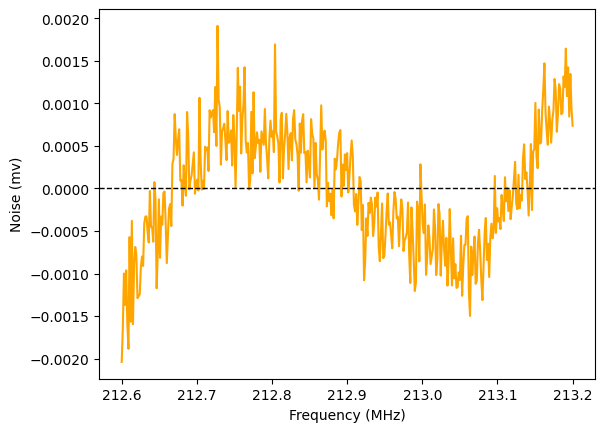

In [277]:
plt.plot(x_vals, error, color='orange')
plt.axhline(y=0, linestyle='--', color='black', linewidth=1)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Noise (mv)')

### Distribution of the noise

* Not that important 

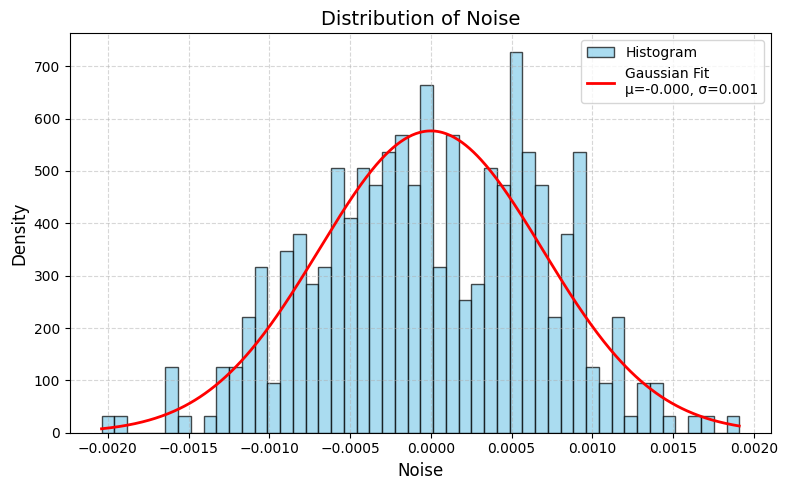

In [278]:
from scipy.stats import norm
plt.figure(figsize=(8, 5))
n, bins, _ = plt.hist(error, bins=50, density=True, color='skyblue', edgecolor='black', alpha=0.7, label='Histogram')
mu, sigma = norm.fit(error)
x = np.linspace(bins[0], bins[-1], 500)
pdf = norm.pdf(x, mu, sigma)
plt.plot(x, pdf, 'r-', lw=2, label=f'Gaussian Fit\nμ={mu:.3f}, σ={sigma:.3f}')
plt.legend()
plt.xlabel('Noise', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Distribution of Noise', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Modeling the noise.

* Fit sinusoidal fit to the noise and extract the amplitude. subtract the sinusoidal fit from noise (error) and again fit the gaussian function to the residual and extract the mean and width of the gausian noise and so on. 

In [279]:
np.random.seed(42)
def sinusoidal_noise(x, A1, f1, phi1,A2, f2, phi2, C): # Amplitude, frequency, phase, offset 
    return A1  * np.sin(2 * np.pi * f1 * x + phi1) + C + A2 * np.cos(2 * np.pi * f2 * x + phi2)#   + np.random.normal(0, sigma, size=len(x_vals))

initial_parameters = [4, 0.8, 200,4, 1, 150, 0.002]
popt, pcov = curve_fit(sinusoidal_noise, x_vals, error, p0=initial_parameters)
print("Fitted parameters:")
print(f"[A1 f1 phi1 A2 f2 phi2 C]= {popt}")

Fitted parameters:
[A1 f1 phi1 A2 f2 phi2 C]= [-5.45647232e-02  7.25053377e-01  2.99242460e+02  5.80900242e-02
  6.58056828e-01  6.07196508e+02  6.54880185e-04]


In [280]:
residuals2 = error - sinusoidal_noise(x_vals, *popt) 
chisq = np.sum((residuals2 / np.std(residuals2)) ** 2)
dof = len(x_vals) - len(popt) 
chi2_red = chisq / dof
pval_2 = 1 - chi2.cdf(chisq, dof)

print(chisq, chi2_red, pval_2)

401.0000000003343 1.0177664974627774 0.39295711857490156


Text(0, 0.5, 'Noise (mV)')

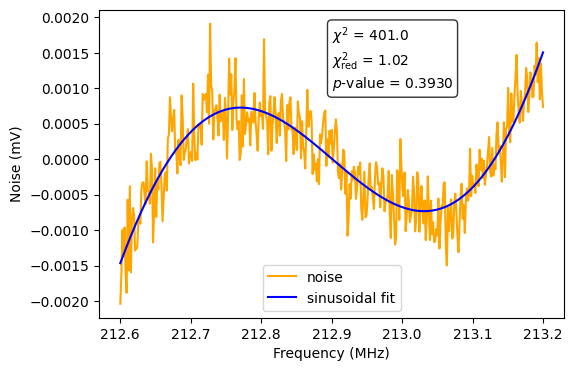

In [281]:
plt.figure(figsize=(6,4))
plt.plot(x_vals, error, color='orange', label='noise')
plt.plot(x_vals, sinusoidal_noise(x_vals, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5], popt[6]), color='blue', label='sinusoidal fit')
plt.legend()

textstr = f"$\chi^2$ = {chisq:.1f}\n" \
          f"$\chi^2_\\mathrm{{red}}$ = {chi2_red:.2f}\n" \
          f"$p$-value = {pval_2:.4f}"
plt.gca().text(0.5, 0.95, textstr, transform=plt.gca().transAxes,
               fontsize=10, verticalalignment='top',
               bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))

plt.xlabel('Frequency (MHz)')
plt.ylabel('Noise (mV)')

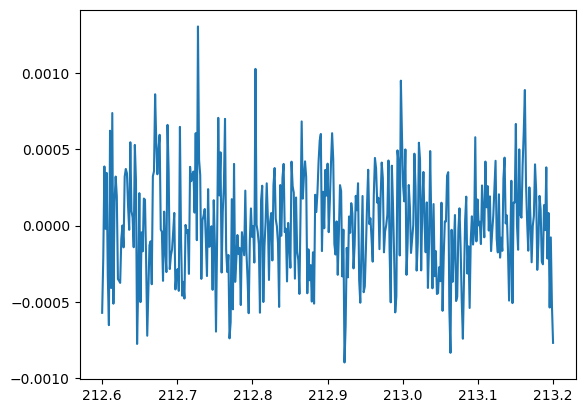

In [282]:
error_2 = error - sinusoidal_noise(x_vals, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5], popt[6])

plt.plot(x_vals, error_2)

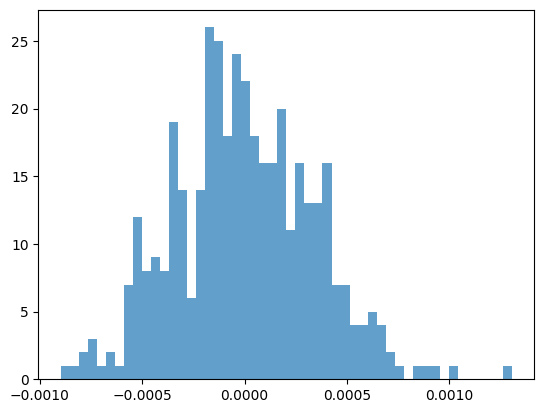

In [283]:
plt.hist(error_2, bins=50, alpha=0.7);

In [284]:
def second_fit(x, mean, sigma):
    return np.random.normal(mean, sigma, size=len(x_vals))# sinusoidal_noise(x_vals, popt[0], popt[1], popt[2], popt[3], popt[4], popt[6], popt[6]) + np.random.normal(mean, sigma, size=len(x_vals))

int_par = [0.00, 0.0004]
popt2, pcov2 = curve_fit(second_fit, x_vals, error, p0=int_par)
print("mean, sigma=")
print(popt2)

mean, sigma=
[0.     0.0004]


In [285]:
residuals3 = error_2 - second_fit(x_vals, *popt2) 
chisq3 = np.sum((residuals3 / np.std(residuals3)) ** 2)
dof = len(x_vals) - len(popt2) 
chi2_red3 = chisq3 / dof
pval_3 = 1 - chi2.cdf(chisq3, dof)

print(chisq3, chi2_red3, pval_3)

401.7585983921774 1.0069137804315222 0.4518383091971794


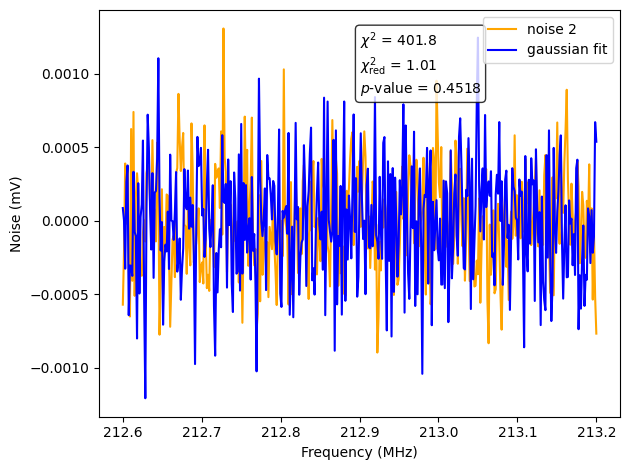

In [286]:
plt.plot(x_vals, error_2, color='orange', label='noise 2')
plt.plot(x_vals, second_fit(x_vals, *popt2), color='blue', label='gaussian fit')
plt.legend()

textstr = f"$\chi^2$ = {chisq3:.1f}\n" \
          f"$\chi^2_\\mathrm{{red}}$ = {chi2_red3:.2f}\n" \
          f"$p$-value = {pval_3:.4f}"
plt.gca().text(0.5, 0.95, textstr, transform=plt.gca().transAxes,
               fontsize=10, verticalalignment='top',
               bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))


plt.xlabel('Frequency (MHz)')
plt.ylabel('Noise (mV)')
plt.tight_layout()

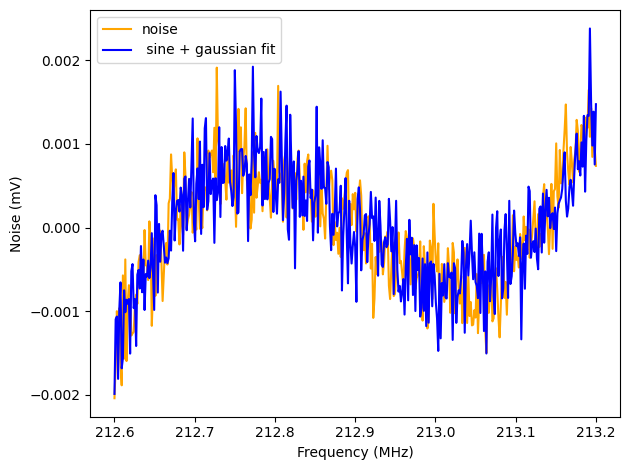

In [287]:
plt.plot(x_vals, error, color='orange', label='noise')
plt.plot(x_vals, sinusoidal_noise(x_vals, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5], popt[6] ) + second_fit(x_vals, popt2[0], popt2[1]), color='blue', label=' sine + gaussian fit')
plt.legend()
plt.xlabel('Frequency (MHz)')
plt.ylabel('Noise (mV)')
plt.tight_layout()